In [1]:
import torch
import torch.nn as nn
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set the random seed for NumPy
np.random.seed(42)

# Set the random seed for PyTorch
torch.manual_seed(42)

In [3]:
comp_name = "MSFT"
raw_data = yf.download(comp_name, period="5y", interval="1mo")
prices = raw_data['Close'].values

[*********************100%%**********************]  1 of 1 completed


In [4]:
period = 5

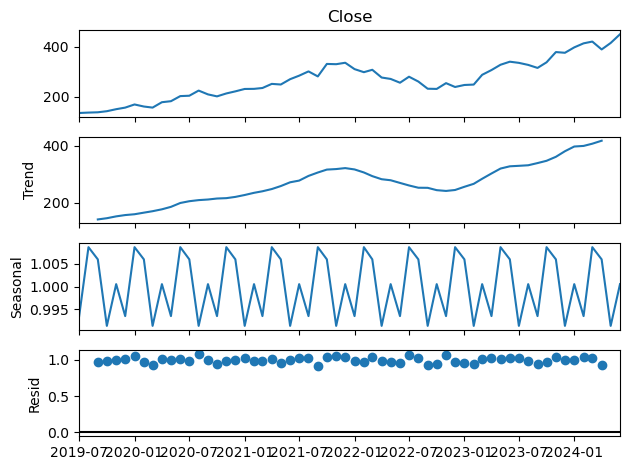

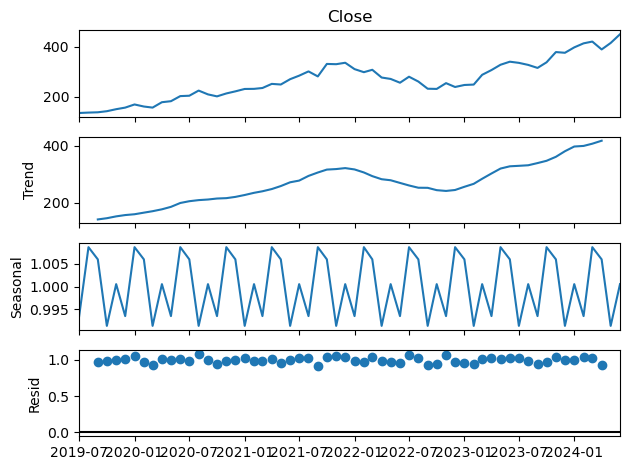

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(raw_data['Close'], model='multiplicative', period=period)
decomposition.plot()

In [6]:
def create_sequences(data, seq_len):
    xs = []
    ys = []
    for i in range(len(data)-seq_len-1):
        x = data[i:i+seq_len]
        y = data[i+seq_len]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_len = period
X, y = create_sequences(prices, seq_len)
scaler = MinMaxScaler(feature_range=(-1,1))
# X = scaler.fit_transform(X)
y = y.reshape(-1, 1)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


class StockDataset(Dataset):
    def __init__(self, X, y):
        super(StockDataset, self).__init__()
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
for x1, y1 in train_loader:
    break

print(x1.shape, y1.shape)

torch.Size([32, 5]) torch.Size([32, 1])


In [17]:
### creating model ###

class transformer_m(nn.Module):
    def __init__(self, input_size, n_layers, n_heads, hidden_dim, dropout=0.1):
        super(transformer_m, self).__init__()
        self.input_size = input_size
        # self.transformer_module = nn.Transformer(d_model=input_size, nhead=n_heads, num_encoder_layers=n_layers,
        #                                          num_decoder_layers=n_layers, dim_feedforward=hidden_dim, dropout=dropout)
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.lrelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, src, tgt):

        # x = self.transformer_module(src, tgt)
        x = self.fc1(src)
        x = self.lrelu(x)
        x = self.fc2(x)
        return x


input_size = period
n_layers = 12
n_heads = 2
hidden_dim = 6


In [29]:
EPOCH = 8
lr = 1e-1

model = transformer_m(input_size, n_layers, n_heads, hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train()
for e in range(EPOCH):
    epoch_l = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(Xb, Xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        epoch_l += loss.item()

    print("Epoch: {:}, Loss: {:.2f}".format(e+1, epoch_l/len(train_loader)))

print("Training Complete !!")

Epoch: 1, Loss: 18134.87
Epoch: 2, Loss: 23806.65
Epoch: 3, Loss: 5127.77
Epoch: 4, Loss: 15104.55
Epoch: 5, Loss: 7367.51
Epoch: 6, Loss: 1252.25
Epoch: 7, Loss: 7062.12
Epoch: 8, Loss: 3269.88
Training Complete !!


In [30]:
model.eval()

y_ac = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        xt, yt = batch
        ypt = model(xt, xt)
        y_ac.extend(yt.numpy().flatten())
        y_pred.extend(ypt.numpy().flatten())
        



In [31]:
# torch.from_numpy(X).unsqueeze(0).shape

In [32]:
def test_price1(model, data, start, end, seq_len):
    model.eval()
    out = [np.nan]*start
    xt = list(data[start-seq_len:start])
    

    with torch.no_grad():
        for i in range(start, end):
            xin = xt
            xin = torch.from_numpy(np.array(xin)).float()
            xin = xin.unsqueeze(0)
            # print(xt.shape)
            yt = model(xin, xin)
            tout = yt.detach().numpy().flatten()[0]
            out.append(tout)
            xt.append(tout)
            xt.pop(0)
            
    
    return out


def test_price(model, data, start, end, seq_len):
    model.eval()
    out = [np.nan]*start
    xt = list(data[start-seq_len:start])
    

    with torch.no_grad():
        for i in range(start, end):
            xin = data[i-seq_len:i]
            xin = torch.from_numpy(np.array(xin)).float()
            xin = xin.unsqueeze(0)
            # print(xt.shape)
            yt = model(xin, xin)
            tout = yt.detach().numpy().flatten()[0]
            out.append(tout)
            
    
    return out

In [37]:
outp = test_price(model, prices, start=30, end=len(prices), seq_len=period)

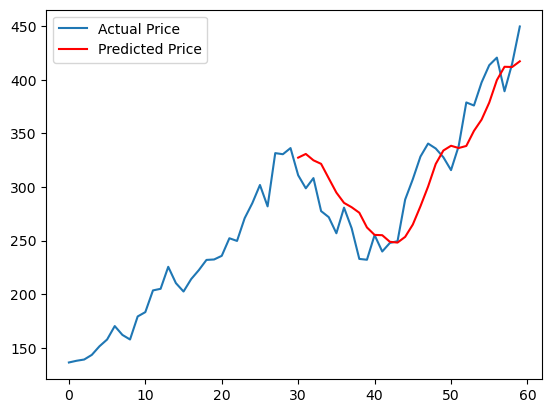

In [38]:
plt.plot(prices, label="Actual Price")
plt.plot(outp, label="Predicted Price", color="red")
plt.legend()
plt.show()

In [16]:
np.savez("latest_reg_out.npz", array1=outp)